#  Project 3: Web APIs & NLP

## Modeling

### Baseline

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC, SVC

In [2]:
df_vectorized = pd.read_csv('./data/cleaned_vectorized_catdog.csv')
df = pd.read_csv('./data/cat_dog.csv')

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Baseline- Check what we need to check in a classification problem.
df['subreddit'].value_counts(normalize = True)

cats    0.52145
dogs    0.47855
Name: subreddit, dtype: float64

### Models

In [5]:
# A function that fit a model on X_train and y_train of the given X and y and print accuracies

def fit_model(X, y, pipe, pipe_params):
    # Split the data into the training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    pipe.fit(X_train, y_train)

    gs = GridSearchCV(pipe, # what object are we optimizing?
                      param_grid = pipe_params, # what parameters values are we searching?
                      cv = 5) # 5-fold cross-validation.

    gs.fit(X_train, y_train)

    print(f'train score: {gs.score(X_train, y_train)}')
    print(f'test score: {gs.score(X_test, y_test)}')

    print(gs.best_params_)
    
    return gs


# A function that returns confusion matrix

def get_confusion_matrix(gs, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    #View Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='bone');

### Modeling Using the `CountVectorizer` and `MultinomialNB`

In [6]:
%%time

# Model #1

pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words = 'english')),
        ('nb', MultinomialNB())
    ])

pipe_params = {
    'cvec__max_features': [500, 1_000, 2_000, 3_000, 4_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

# Call the fit model function
model_1 = fit_model(df['text'],
                    df['subreddit'],
                    pipe,
                    pipe_params)

train score: 0.8965161822304679
test score: 0.8868624420401855
{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
Wall time: 2min 8s


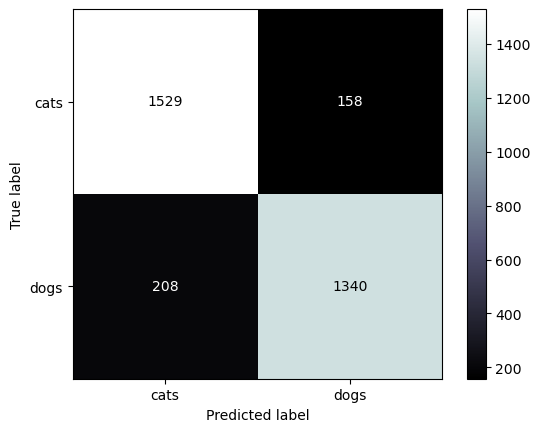

In [7]:
# Get confusion matrxi for model#1
get_confusion_matrix(model_1,
                     df['text'],
                     df['subreddit'])

### Modeling Using the `TfidfVectorizer` and `MultinomialNB`

In [8]:
%%time

# Model #2

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

model_2 = fit_model(df['text'],
                    df['subreddit'],
                    pipe,
                    pipe_params)

train score: 0.909297052154195
test score: 0.8757341576506955
{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Wall time: 46.4 s


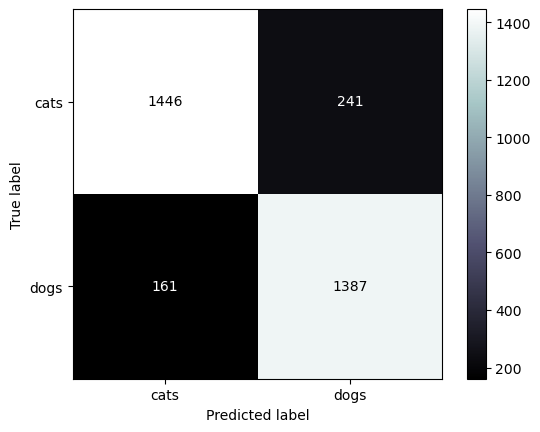

In [9]:
# Get confusion matrxi for model#2
get_confusion_matrix(model_2,
                     df['text'],
                     df['subreddit'])

### Modeling Using the `TfidfVectorizer` and `RandomForestClassifier`

In [10]:
%%time

# Model #3

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [150, 200, 300, 400],
    'rf__max_depth': [3, 4, 5, 6, 7]
}

model_3 = fit_model(df['text'],
                    df['subreddit'],
                    pipe,
                    pipe_params)

train score: 0.8487940630797773
test score: 0.8343122102009274
{'rf__max_depth': 7, 'rf__n_estimators': 300, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1)}
Wall time: 16min 51s


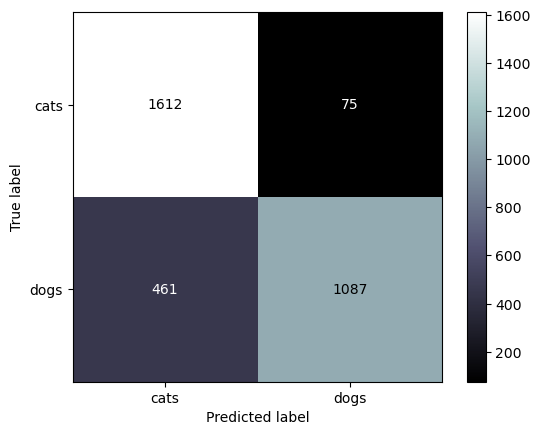

In [11]:
# Get confusion matrxi for model#3
get_confusion_matrix(model_3, 
                     df['text'],
                     df['subreddit'])

### The effect of hyperparameter n_estimators on train and test scores

In [12]:
X = df['text']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [13]:
# Let's see what ranges we should put in our gridsearch(less brut-forcing!)
n_estimator = [n for n in range(100, 550, 50)]
cv_score = []
score_train =[]
score_test = []
for n in n_estimator:
    pipe_tvec_rf = Pipeline([
        ('tvec', TfidfVectorizer(stop_words='english', max_features=4000, ngram_range=(1, 2))),
        ('rf', RandomForestClassifier(n_estimators=n, max_depth=6))
    ])
    cv_score.append(cross_val_score(pipe_tvec_rf, X_train, y_train, cv=5).mean())
    pipe_tvec_rf.fit(X_train, y_train)
    score_train.append(pipe_tvec_rf.score(X_train, y_train))
    score_test.append(pipe_tvec_rf.score(X_test, y_test))

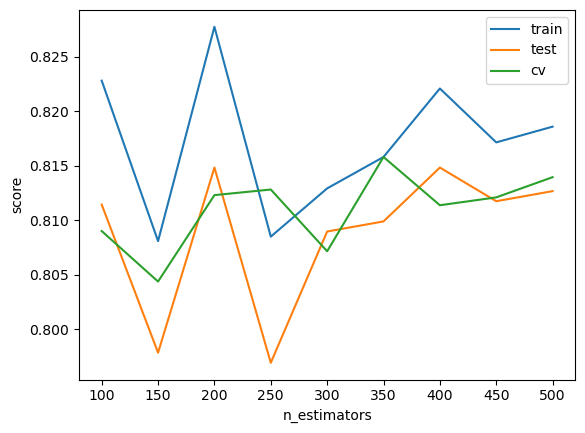

In [14]:
# Plot the change of scores while changing n_estimator hyperparameter, all else held equal.

plt.plot(n_estimator, score_train, label='train')
plt.plot(n_estimator, score_test, label='test')
plt.plot(n_estimator, cv_score, label='cv')
plt.legend()
plt.ylabel('score')
plt.xlabel('n_estimators');

### The effect of hyperparameter max_depth on train and test scores

In [15]:
# Let's see what ranges we should put in our gridsearch(less brut-forcing!)
max_depth = [n for n in range(5, 10)]
cv_score = []
score_train =[]
score_test = []
for n in max_depth:
    pipe_tvec_rf = Pipeline([
        ('tvec', TfidfVectorizer(stop_words='english', max_features=4000, ngram_range=(1, 2))),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=n))
    ])
    cv_score.append(cross_val_score(pipe_tvec_rf, X_train, y_train, cv=5).mean())
    pipe_tvec_rf.fit(X_train, y_train)
    score_train.append(pipe_tvec_rf.score(X_train, y_train))
    score_test.append(pipe_tvec_rf.score(X_test, y_test))

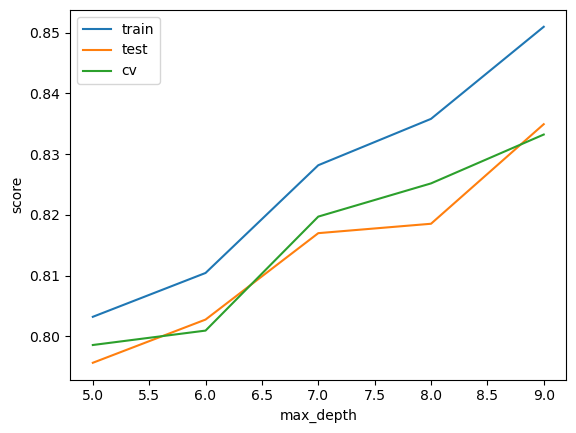

In [16]:
# Plot the change of scores while changing max_depth hyperparameter, all else held equal.

plt.plot(max_depth, score_train, label='train')
plt.plot(max_depth, score_test, label='test')
plt.plot(max_depth, cv_score, label='cv')
plt.legend()
plt.ylabel('score')
plt.xlabel('max_depth');

### Modeling Using the `TfidfVectorizer` and `LogsiticRegression`

In [17]:
%%time

# Model #4

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(solver='saga'))
])

pipe_params= {
    'tvec__max_features': [3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1,2)],
    'logreg__penalty': ['l1', 'l2', None],
    'logreg__C': [1.0, 1.5, 2]
}

model_4 = fit_model(df['text'],
                    df['subreddit'],
                    pipe, 
                    pipe_params)

train score: 0.9503195217480932
test score: 0.9032457496136013
{'logreg__C': 2, 'logreg__penalty': 'l2', 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
Wall time: 8min 46s


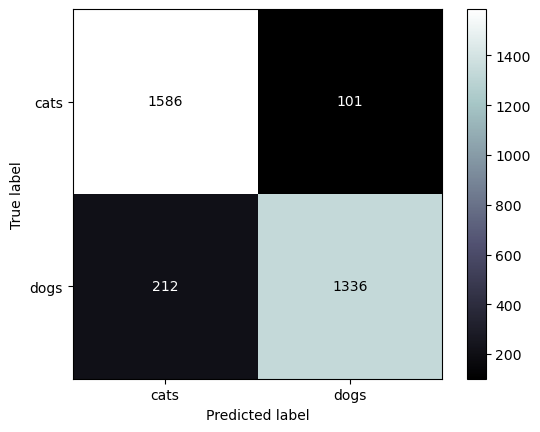

In [18]:
# Get confusion matrxi for model#4
get_confusion_matrix(model_4,
                     df['text'],
                     df['subreddit'])

### The effect of hyperparameter C on train and test scores

In [19]:
# Let's see what ranges we should put in our gridsearch(less brut-forcing!)
C_list = [i/2 for i in range(1,10)]
cv_score = []
score_train =[]
score_test = []
for c in C_list:
    pipe_tvec_logreg = Pipeline([
        ('tvec', TfidfVectorizer(stop_words='english', max_features=4000, ngram_range=(1, 2))),
        ('logreg', LogisticRegression(C=c))
    ])
    cv_score.append(cross_val_score(pipe_tvec_logreg, X_train, y_train, cv=5).mean())
    pipe_tvec_logreg.fit(X_train, y_train)
    score_train.append(pipe_tvec_logreg.score(X_train, y_train))
    score_test.append(pipe_tvec_logreg.score(X_test, y_test))

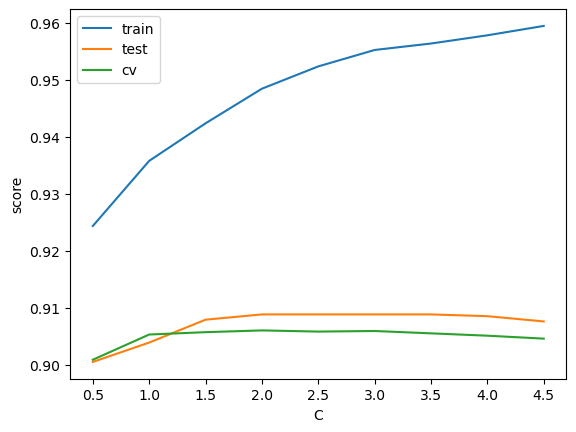

In [20]:
#Visualize how different values of C affect accuracy
plt.plot(C_list, score_train, label='train')
plt.plot(C_list, score_test, label='test')
plt.plot(C_list, cv_score, label='cv')
plt.legend()
plt.ylabel('score')
plt.xlabel('C');

### The effect of hyperparameter max_features on train and test scores

In [21]:
max_feature_list = [i for i in range(500, 6000, 200)]
score_train =[]
score_test = []
for i in max_feature_list:
    pipe_tvec_logreg = Pipeline([
        ('tvec', TfidfVectorizer(stop_words='english', max_features=i, ngram_range=(1, 2))),
        ('logreg', LogisticRegression(C=1.5))
    ])
    pipe_tvec_logreg.fit(X_train, y_train)
    score_train.append(pipe_tvec_logreg.score(X_train, y_train))
    score_test.append(pipe_tvec_logreg.score(X_test, y_test))

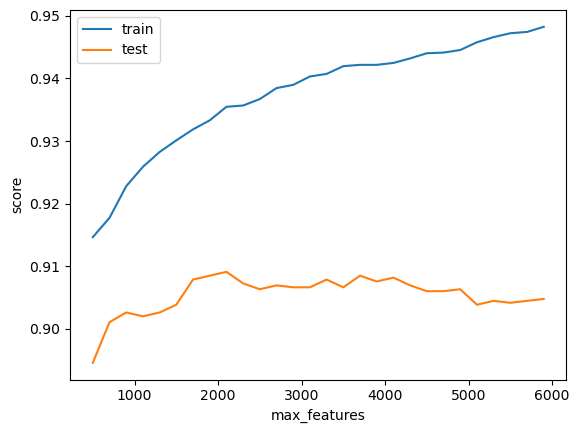

In [22]:
#Visualize how different values of max_fetaures affect accuracy
plt.plot(max_feature_list, score_train, label='train')
plt.plot(max_feature_list, score_test, label='test')
plt.legend()
plt.ylabel('score')
plt.xlabel('max_features');

### Modeling Using the `TfidfVectorizer` and `LinearSVM`

In [23]:
%%time

# Model #5  

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', LinearSVC())
])
    
pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'svc__C': np.linspace(0.0001, 2, 10),
    'svc__penalty': ['l1', 'l2']
}

model_5 = fit_model(df['text'],
                    df['subreddit'], 
                    pipe, 
                    pipe_params)

train score: 0.950628736343022
test score: 0.9063369397217929
{'svc__C': 0.2223111111111111, 'svc__penalty': 'l2', 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1)}
Wall time: 7min 54s


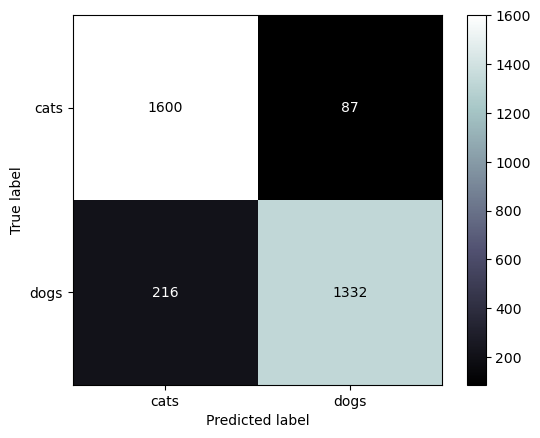

In [24]:
# Get confusion matrxi for model#5
get_confusion_matrix(model_5,
                     df['text'],
                     df['subreddit'])

### Modeling Using the `TfidfVectorizer` and `SVM`

In [25]:
%%time

# Model #6

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC())
])
    
pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'svc__C': np.linspace(0.0001, 1, 5)
}

model_6 = fit_model(df['text'],
                    df['subreddit'],
                    pipe,
                    pipe_params)

train score: 0.98433312719027
test score: 0.9088098918083463
{'svc__C': 1.0, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1)}
Wall time: 18min 25s


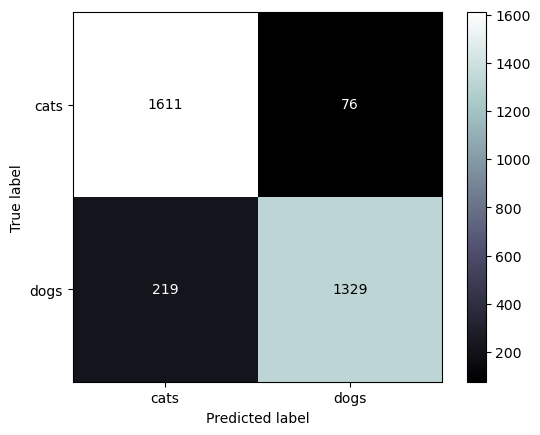

In [26]:
# Get confusion matrxi for model#6
get_confusion_matrix(model_6,
                     df['text'],
                     df['subreddit'])

### Modeling Using the `CounVectorizer` and `SVM`

In [27]:
# Model #7

pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words = 'english')),
        ('svc', SVC())
    ])

pipe_params = {
    'cvec__max_features': [500, 1_000, 2_000, 3_000, 4_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

model_7 = fit_model(df['text'],
                    df['subreddit'],
                    pipe, 
                    pipe_params)

train score: 0.9076479076479076
test score: 0.8825347758887172
{'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}


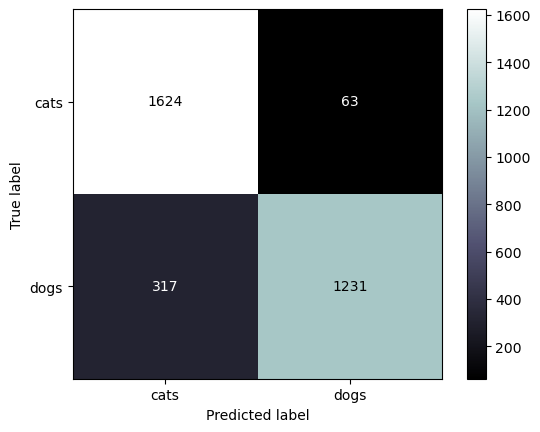

In [28]:
# Get confusion matrxi for model#7
get_confusion_matrix(model_7,
                     df['text'],
                     df['subreddit'])

## Ensemble Model

In [29]:
%%time

vc = VotingClassifier([
    ('model_1', model_1),
    ('model_2', model_2),
    ('model_4', model_4),
    ('model_5', model_5),
    ('model_6', model_6),
    ('model_7', model_7)
])

vc.fit(X_train, y_train)

print(f'train score: {vc.score(X_train, y_train)}')
print(f'test score: {vc.score(X_test, y_test)}')

train score: 0.950731807874665
test score: 0.9057187017001546
Wall time: 49min 8s


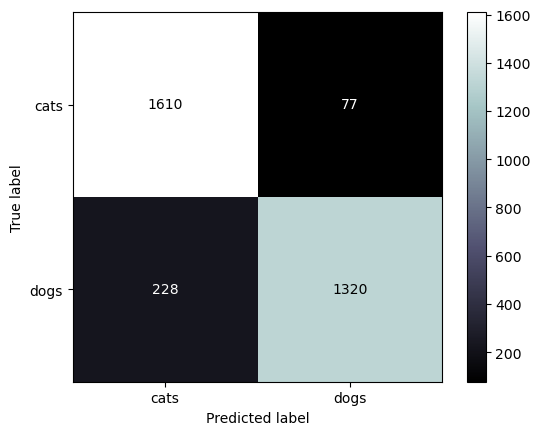

In [31]:
# Get confusion matrxi for model#7
preds = vc.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

#View Confusion Matrix
plot_confusion_matrix(vc, X_test, y_test, cmap='bone');

plt.savefig('./imgs/confusion_matrix.png', bbox_inches='tight', dpi=300)